In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import default_collate
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import SpearmanCorrCoef

In [3]:
def get_image_data(method: str, net_out: str, task: str, scanner: int):
    directory = f'../../experiments/results/eval/{net_out}/image/'
    image_data = []
    for file in os.listdir(directory):
        if method in file and task in file and scanner in file[:-2]:
            f = torch.load(directory + file)
            f['corr'].target = [t.cpu() for t in f['corr'].target]
            f['corr'].preds = [t.cpu() for t in f['corr'].preds]
            f['corr'] = f['corr'].compute()
            image_data.append(f)
    
    return default_collate(image_data)

In [202]:
net_out='calgary'
directory = f'../../experiments/results/eval/{net_out}/image/'

#file = 'calgary-entropy-corr-1-0_baloon' 
#file = 'calgary-ae-corr-1-0_baloon'
file='calgary-gonzales-corr-1-0_baloon'
#file='calgary-latents-corr-1-0_baloon'
#file='calgary-entropy-corr-2-0_baloon'
#file='calgary-ae-corr-2-0_baloon'
tmp = torch.load(directory + file)

In [203]:
# Entropy

tmp['corr'].compute()

tensor(0.0868)

In [186]:
# AE

tmp['corr'].compute()

tensor(0.6856)

# OOD Detection. MMS only

In [166]:
df_ood_mms = pd.DataFrame(columns=['method', 'Domain', 'run', 'Accuracy'])
for method in ['gonzales', 'latents', 'entropy', 'ae']:
    for scanner in ['val', 'A', 'B', 'C','D']:
        tmp = get_image_data(method=method, 
                             net_out='mms', 
                             task='both', 
                             scanner=str(scanner))
        
        if scanner == 'A':
            domain = 'Siemens \n'
        if scanner == 'B':
            domain = 'Philips'
        if scanner == 'C':
            domain = 'GE'
        if scanner == 'D':
            domain = 'Canon'
        if scanner == 'val':
            continue
            
        if method == 'gonzales':
            m = 'PM'
        if method == 'entropy':
            m = 'EN'
        if method == 'latents':
            m = 'LM'
        if method == 'ae':
            m = 'SD'
            
        for i, ood in enumerate(tmp['ood']):
            row = {'Domain': domain, 
                   'method': m, 
                   'run': i, 
                   'Accuracy': ood.numpy().item()}

            df_ood_mms = df_ood_mms.append(row, ignore_index=True)

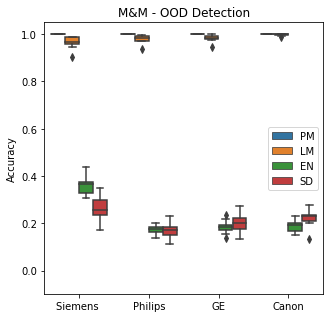

In [268]:

fig, axes = plt.subplots(1, 1, figsize=(5,5),  gridspec_kw={'hspace': 0})
axes.set_title('M&M - OOD Detection')

sns.boxplot(ax=axes, x="Domain", y="Accuracy",
        hue="method", data=df_ood_mms)
axes.legend().set_title('')
axes.set_xlabel("")
axes.set_ylim(-0.1, 1.05)
fig.savefig("../../experiments/results/eval/mms_ood.jpg", bbox_inches='tight')

# Unet Performance M&M only

In [222]:
heart = np.load('../../experiments/results/unet/heart_unet_results.npy', allow_pickle=True).item()

In [265]:
df = pd.DataFrame(columns = ['DCS', 'Domain'])
for key in heart:
    
    if 'acdc_train' in key:
        continue
    if 'acdc_val' in key:
        domain = 'Siemens \n(val)'
    
    if 'siemens' in key:
        domain = 'Siemens'
    if 'philips' in key:
        domain = 'Philips'
    if 'canon' in key:
        domain = 'Canon'
    if 'ge' in key:
        domain = 'GE'
    
    values = np.array([heart[key], [domain]*10]).T
    for value in values:
        row = {'DCS': value[0],
               'Domain': value[1]}
        #print(row)
        df = df.append(row, ignore_index=True)
    #df.append([heart[key], [key]*10], ignore_index=True)

In [266]:
df['DCS'] = df['DCS'].astype(float)

In [269]:
df = pd.read_csv("../../experiments/results/eval/mms_dcs.pd")
df['Vendor'] = df['Vendor'].replace("M&M - Philips", "Philips")
df['Vendor'] = df['Vendor'].replace("M&M - GE", "GE")
df['Vendor'] = df['Vendor'].replace("M&M - Siemens", "Siemens")
df['Vendor'] = df['Vendor'].replace("M&M - Canon", "Canon")
df['Vendor'] = df['Vendor'].replace("ACDC - Siemens (val)", "Siemens \n(val)")

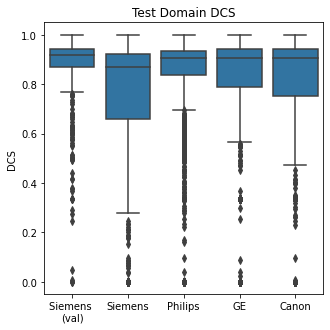

In [287]:
fig, axes = plt.subplots(1, 1, figsize=(5,5),  gridspec_kw={'hspace': 0})

sns.boxplot(ax=axes, x="Vendor", y="DCS", data=df, color='tab:blue')
axes.set_title("Test Domain DCS")
axes.set_xlabel("")
#axes.set_ylim(0.6, 0.9)
fig.savefig("../../experiments/results/eval/mms_dcs.jpg", bbox_inches='tight')

# Correlation Calgary

In [216]:
df_corr_calgary = pd.DataFrame(columns=['method', 'Domain', 'run', r'Spearmans $\rho$'])
#for method in ['gonzales', 'latents', 'vae']:
for method in ['gonzales', 'latents', 'entropy', 'ae']:
    for scanner in [6, 1, 2, 3, 4, 5]:
        try:
            tmp = get_image_data(method=method, 
                                 net_out='calgary', 
                                 task='both', 
                                 scanner=str(scanner))
        except:
            tmp = get_image_data(method=method, 
                     net_out='calgary', 
                     task='corr', 
                     scanner=str(scanner))
        
        if scanner == 1:
            domain = 'GE 1.5'
        if scanner == 2:
            domain = 'GE 3.0'
        if scanner == 3:
            domain = 'Philips 1.5'
        if scanner == 4:
            domain = 'Philips 3.0'
        if scanner == 5:
            domain = 'Siemens 1.5'
        if scanner == 6:
            domain = 'Siemens 3.0 \n(val)'
        
        
        for i, corr in enumerate(tmp['corr']):

            row = {'Domain': domain, 
                   'method': method, 
                   'run': i, 
                   r'Spearmans $\rho$': corr.numpy().item()}

            df_corr_calgary = df_corr_calgary.append(row, ignore_index=True)


# Correlation MMS

In [4]:
df_corr_mms = pd.DataFrame(columns=['method', 'Domain', 'run', r'Spearmans $\rho$'])
for method in ['gonzales', 'latents', 'entropy', 'ae']:
    for scanner in ['val', 'A', 'B', 'C', 'D']:
    #for scanner in ['A', 'B', 'C']:
        tmp = get_image_data(method=method, 
                             net_out='mms', 
                             task='both', 
                             scanner=str(scanner))
        
        if scanner == 'A':
            domain = 'Siemens'
        if scanner == 'B':
            domain = 'Philips'
        if scanner == 'C':
            domain = 'GE'
        if scanner == 'D':
            domain = 'Canon'
        if scanner == 'val':
            domain = 'Siemens \n(val)'
            
            
        if method == 'gonzales':
            m = 'PM'
        if method == 'entropy':
            m = 'EN'
        if method == 'latents':
            m = 'LM'
        if method == 'ae':
            m = 'SD'
        
        for i, corr in enumerate(tmp['corr']):

            row = {'Domain': domain, 
                   'method': m, 
                   'run': i, 
                   r'Spearmans $\rho$': corr.numpy().item()}

            df_corr_mms = df_corr_mms.append(row, ignore_index=True)

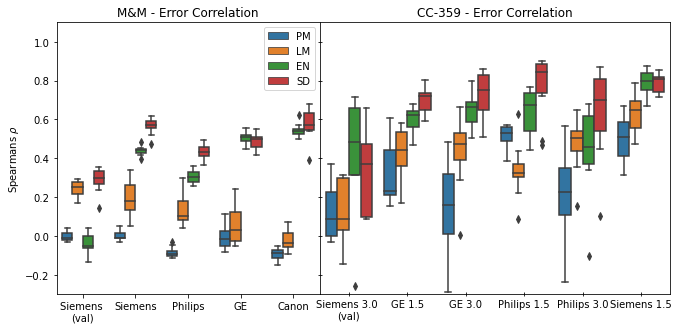

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True, gridspec_kw={'width_ratios': [12, 16]})
sns.boxplot(ax = axes[0], x="Domain", y=r'Spearmans $\rho$',
            hue="method", data=df_corr_mms)
#axes[0].get_legend().remove()
axes[0].legend().set_title('')
axes[0].set_title('M&M - Error Correlation')
axes[0].set_xlabel("")

sns.boxplot(ax = axes[1], x="Domain", y=r'Spearmans $\rho$',
            hue="method", data=df_corr_calgary)
axes[1].get_legend().remove()
axes[1].set_title('CC-359 - Error Correlation')

#axs_right[1].set_yticks([])
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].tick_params(direction='inout')
axes[1].set_ylim(-0.3, 1.1)
fig.subplots_adjust(wspace=0, hspace=0)
#sfigs[1].subplots_adjust(wspace=0, hspace=0)
#fig.colorbar(pcm, ax=axs_right)
#fig.suptitle('Nested plots using subfigures')
#fig.savefig("image_wise.jpg")
fig.savefig("../../experiments/results/eval/err_corr.jpg", bbox_inches='tight')

In [7]:
df_corr_mms[
    (df_corr_mms['run'] == 0) &
    (df_corr_mms['method'] == 'SD')
           
           ]

,method,Domain,run,Spearmans $\rho$
150,SD,Siemens \n(val),0,0.143936
160,SD,Siemens,0,0.588468
170,SD,Philips,0,0.430325
180,SD,GE,0,0.488521
190,SD,Canon,0,0.561310


ValueError: Could not interpret input 'Pearson's Correlation'

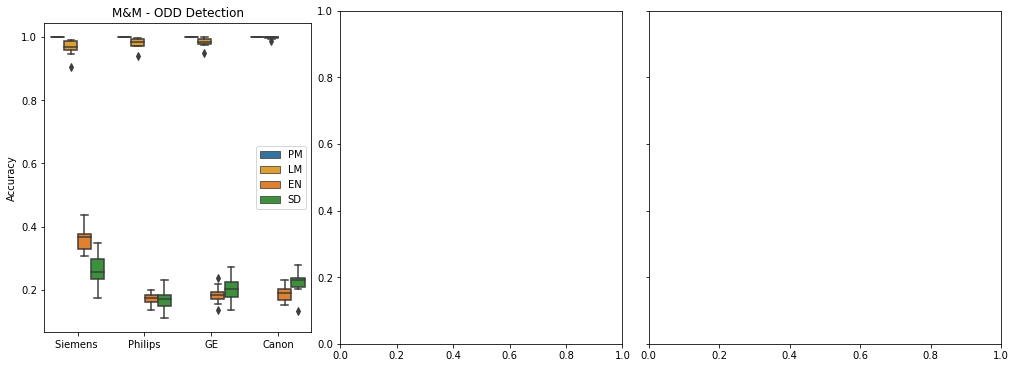

In [218]:
fig = plt.figure(layout="constrained", figsize=(14,5))
sfigs = fig.subfigures(1, 2, width_ratios=[12, 12+15], wspace=0)

axs_left = sfigs[0].subplots(1, 1, gridspec_kw={'hspace': 0})
axs_left.set_title('M&M - ODD Detection')

sns.boxplot(ax=axs_left, x="Domain", y="Accuracy",
        hue="method", data=df_ood_mms, palette=custom_palette)
axs_left.legend().set_title('')
axs_left.set_xlabel("")

axs_right = sfigs[1].subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [12, 15]})
sns.boxplot(ax = axs_right[0], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_mms)
axs_right[0].get_legend().remove()
axs_right[0].set_title('M&M - Error Correlation')
axs_right[0].set_xlabel("")

sns.boxplot(ax = axs_right[1], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_calgary)
axs_right[1].get_legend().remove()
axs_right[1].set_title('CC-359 - Error Correlation')

#axs_right[1].set_yticks([])
axs_right[1].set_ylabel("")
axs_right[1].set_xlabel("")
axs_right[1].tick_params(direction='inout')
axs_right[1].set_ylim(-0.3, 1.1)
fig.subplots_adjust(wspace=0)
#sfigs[1].subplots_adjust(wspace=0, hspace=0)
#fig.colorbar(pcm, ax=axs_right)
#fig.suptitle('Nested plots using subfigures')
fig.savefig("image_wise.jpg")

# Correlation, Calgary and MMS

In [66]:
df_corr = pd.DataFrame(columns=['method', 'scanner', 'run', 'corr'])
for net_out in ['mms', 'calgary']:
    for method in ['gonzales', 'latents_noseg', 'latents', 'vae']:
        for scanner in ['A','C','D', 1, 2, 3, 4, 5]:
            try:
                tmp = get_image_data(method=method, 
                                     net_out=net_out, 
                                     task='both', 
                                     scanner=str(scanner))

                for i, corr in enumerate(tmp['corr']):
                    prefix = 'M&M' if net_out == 'mms' else 'CC'
                    row = {'Domain': f'{prefix}: {scanner}', 
                           'method': method, 
                           'run': i, 
                           'Pearson\'s Correlation': corr.numpy().item()}

                    df_corr = df_corr.append(row, ignore_index=True)
            except:
                print(net_out, method, scanner)
            

mms gonzales 1
mms gonzales 2
mms gonzales 3
mms gonzales 4
mms gonzales 5
mms latents_noseg 1
mms latents_noseg 2
mms latents_noseg 3
mms latents_noseg 4
mms latents_noseg 5
mms latents 1
mms latents 2
mms latents 3
mms latents 4
mms latents 5
mms vae 1
mms vae 2
mms vae 3
mms vae 4
mms vae 5
calgary gonzales A
calgary gonzales C
calgary gonzales D
calgary latents_noseg A
calgary latents_noseg C
calgary latents_noseg D
calgary latents_noseg 1
calgary latents_noseg 2
calgary latents_noseg 3
calgary latents_noseg 4
calgary latents_noseg 5
calgary latents A
calgary latents C
calgary latents D
calgary vae A
calgary vae C
calgary vae D


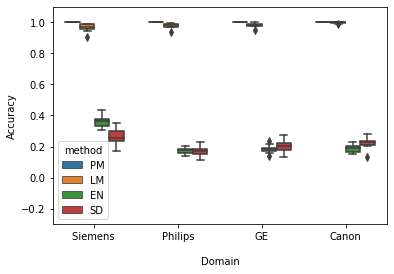

In [167]:
sns_plot = sns.boxplot(x="Domain", y="Accuracy",
            hue="method", data=df_ood_mms, width=0.7)
plt.ylim(-0.3, 1.1)
fig = sns_plot.get_figure()
fig.savefig("mms_ood.jpg")

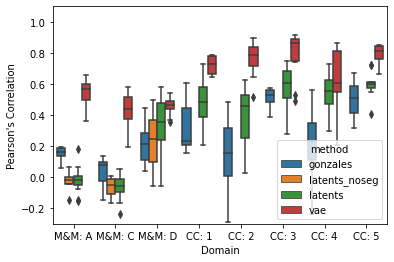

In [77]:
sns_plot = sns.boxplot(x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr)
plt.ylim(-0.3, 1.1)
fig = sns_plot.get_figure()
fig.savefig("correlation.jpg")

In [173]:
for method in ['gonzales', 'latents', 'entropy', 'ae']:
    print(method)
    for scanner in [6, 1, 2, 3, 4, 5]:
        print(scanner)
        try:
            tmp = get_image_data(method=method, 
                                 net_out='calgary', 
                                 task='both', 
                                 scanner=str(scanner))
        except:
            tmp = get_image_data(method=method, 
                     net_out='calgary', 
                     task='corr', 
                     scanner=str(scanner))

gonzales
6
1
2
3
4
5
latents
6
1
2
3
4
5
entropy
6
1
2
3
4
5
ae
6
1
2
3
4
5


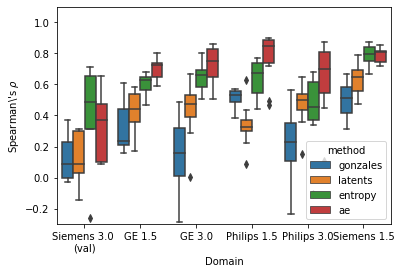

In [175]:
sns_plot = sns.boxplot(x="Domain", y=r'Spearman\'s $\rho$',
            hue="method", data=df_corr_calgary)
plt.ylim(-0.3, 1.1)
fig = sns_plot.get_figure()
#fig.savefig("calgary_correlation.jpg")

In [161]:
for scanner in ['val', 'A', 'B', 'C', 'D']:
    tmp = get_image_data(method='entropy', 
                             net_out='mms', 
                             task='both', 
                             scanner=str(scanner))

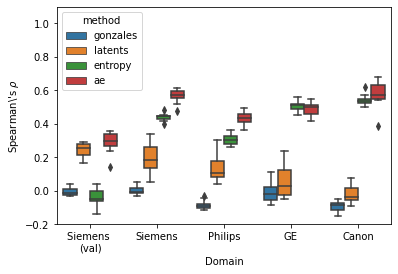

In [164]:
sns_plot = sns.boxplot(x="Domain", y=r'Spearman\'s $\rho$',
            hue="method", data=df_corr_mms)
plt.ylim(-0.2, 1.1)
fig = sns_plot.get_figure()
#fig.savefig("mms_correlation.jpg")

Text(0, 0.5, '')

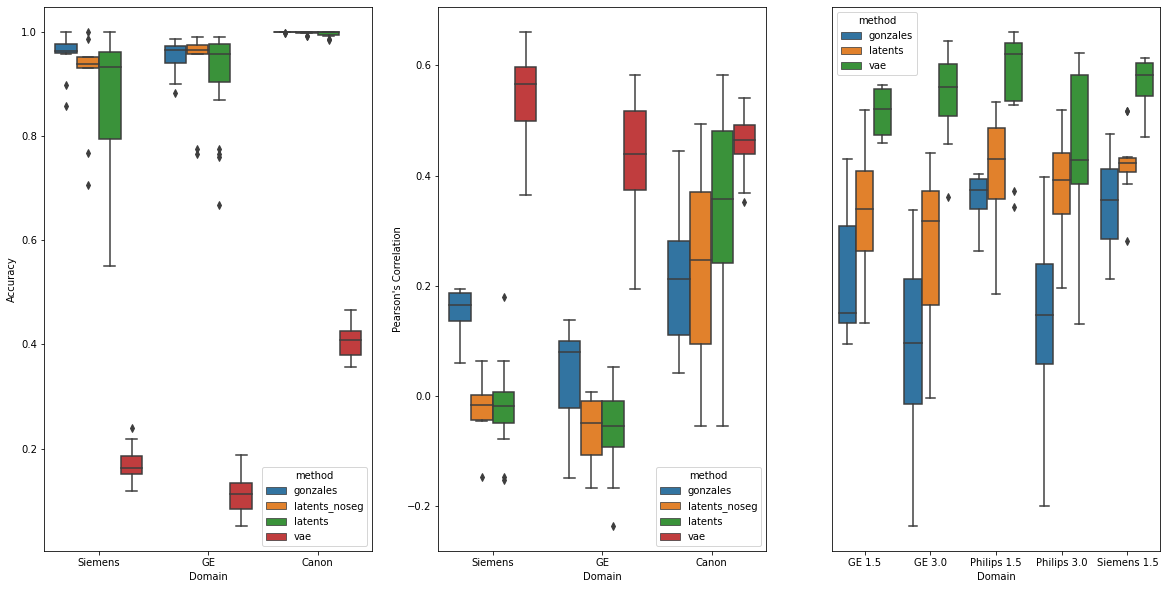

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.boxplot(ax=axes[0], x="Domain", y="Accuracy",
            hue="method", data=df_ood_mms)
sns.boxplot(ax = axes[1], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_mms)
sns.boxplot(ax = axes[2], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_calgary)
axes[2].set_yticks([])
axes[2].set_ylabel("")

In [93]:
custom_palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                  (1.0, 0.65, 0.05),
                  (1.0, 0.4980392156862745, 0.054901960784313725),
                  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                  (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [212]:
heart = np.load('../../experiments/results/unet/heart_unet_results.npy', allow_pickle=True).item()

In [213]:
heart

{'acdc_train': [0.9232203477456165,
  0.9233476671933813,
  0.9118280954197618,
  0.9118913898197872,
  0.9280715073521429,
  0.9177503934490822,
  0.91392248350641,
  0.92178414626555,
  0.9218123036882152,
  0.9230624241005919],
 'acdc_val': [0.878472829858462,
  0.8778105725844702,
  0.8751412332057953,
  0.8791648099819819,
  0.8797796120246252,
  0.8723447720209757,
  0.8723686039447784,
  0.8787884960571924,
  0.8748773733774821,
  0.8779652814070383],
 'mnm_siemens': [0.7771733596459547,
  0.7822606414827927,
  0.7932889080438458,
  0.7249556852603002,
  0.7875660142177658,
  0.7653091953751819,
  0.7871573771501065,
  0.7770731049591509,
  0.7452223182593104,
  0.781899061359343],
 'mnm_philips': [0.8417588769712744,
  0.8317428264628749,
  0.8282225971687571,
  0.8155998912027259,
  0.8312748330817992,
  0.8196808872215681,
  0.831452784170083,
  0.8307789684154155,
  0.8078286273744772,
  0.8314922239453751],
 'mnm_ge': [0.8344716297255622,
  0.8130274530914094,
  0.839806949

In [44]:
df = pd.DataFrame(columns=['method', 'scanner', 'run', 'corr', 'acc'])

for method in ['gonzales', 'vae']:
    for scanner in [1,2,3,4,5]:
        tmp = get_image_data(method=method, 
                             net_out='calgary', 
                             task='both', 
                             scanner=str(scanner))
        for i, corr in enumerate(tmp['corr']):
            row = {'scanner': 'CC-359', 
                   'method': method, 
                   'run': i, 
                   'corr': corr.numpy().item(), 
                   'ood': tmp['ood'][i].numpy().item()}

            df = df.append(row, ignore_index=True)
            

In [45]:
#df = pd.DataFrame(columns=['method', 'scanner', 'run', 'corr', 'ood'])
for method in ['gonzales', 'latents_noseg', 'latents', 'vae']:
    for scanner in ['A','C','D']:
        tmp = get_image_data(method=method, 
                             net_out='mms', 
                             task='both', 
                             scanner=str(scanner))
        for i, corr in enumerate(tmp['corr']):
            row = {'scanner': f'M&M: {scanner}', 
                   'method': method, 
                   'run': i, 
                   'corr': corr.numpy().item(), 
                   'ood': tmp['ood'][i].numpy().item()}

            df = df.append(row, ignore_index=True)
            

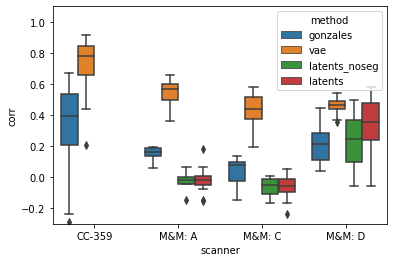

In [46]:
sns_plot = sns.boxplot(x="scanner", y="corr",
            hue="method", data=df)
plt.ylim(-0.3, 1.1)
fig = sns_plot.get_figure()
#fig.savefig("mms_correlation.jpg")

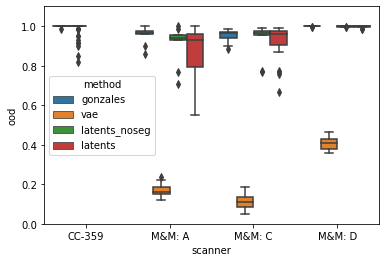

In [47]:
sns_plot = sns.boxplot(x="scanner", y="ood",
            hue="method", data=df)
plt.ylim(0, 1.1)
fig = sns_plot.get_figure()
# fig.savefig("mms_ood_accuracy.jpg")

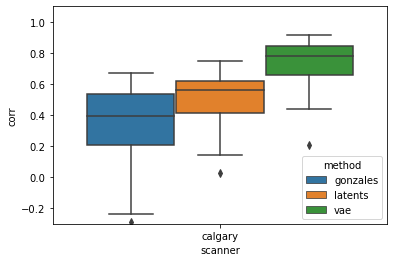

In [24]:
sns_plot = sns.boxplot(x="scanner", y="corr",
            hue="method", data=df)
plt.ylim(-0.3, 1.1)
fig = sns_plot.get_figure()
#fig.savefig("calgary_correlation.jpg")

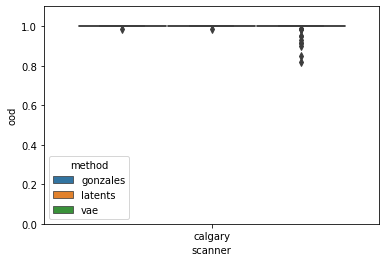

In [25]:
sns_plot = sns.boxplot(x="scanner", y="ood",
            hue="method", data=df)
plt.ylim(0, 1.1)
fig = sns_plot.get_figure()
#fig.savefig("calgary_ood_accuracy.jpg")

In [63]:
import sys
sys.path.append('..')
from utils import Metrics

def get_pixel_data(method: str, net_out: str, scanner: int):
    directory = f'../../experiments/results/eval/{net_out}/pixel/'
    pixel_data = []
    for file in os.listdir(directory):
        if method in file and scanner in file[:-2]:
            f = torch.load(directory + file)
            pixel_data.append(f)
    
    return pixel_data

In [67]:
df_pr_calgary = pd.DataFrame(columns=['method', 'Domain', 'run', 'AUC Precision-Recall'])

out = None
best = 0

for method in ['base', 'ensemble', 'ae']:
#for method in ['latents']:
    for scanner in [6,1,2,3,4,5]:
        tmp = get_pixel_data(method=method, 
                             net_out='calgary', 
                             scanner=str(scanner))
        for i, metric_obj in enumerate(tmp):
            if metric_obj.auc_pr.item() > best:
                best = i
                out=metric_obj
            
            if scanner == 1:
                domain = 'GE 1.5'
            if scanner == 2:
                domain = 'GE 3.0'
            if scanner == 3:
                domain = 'Philips 1.5'
            if scanner == 4:
                domain = 'Philips 3.0'
            if scanner == 5:
                domain = 'Siemens 1.5'
            if scanner == 6:
                domain = 'Siemens 3.0 \n(val)'

            if method == 'base':
                m = 'Entropy'
            if method == 'ensemble':
                m = 'Ensemble'
            if method == 'ae':
                m = 'SD (ours)'

            row = {'Domain': domain, 
                   'method': m, 
                   'run': i,
                   'AUC Precision-Recall': metric_obj.auc_pr.item()}

            df_pr_calgary = df_pr_calgary.append(row, ignore_index=True)

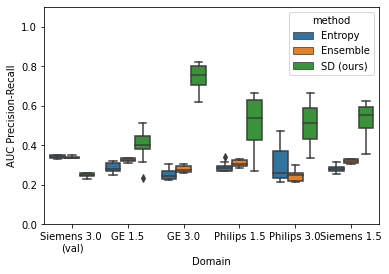

In [68]:
sns_plot = sns.boxplot(x="Domain", y="AUC Precision-Recall",
            hue="method", data=df_pr_calgary)
plt.ylim(0, 1.1)
fig = sns_plot.get_figure()
fig.savefig("calgary_auc_pr.jpg")

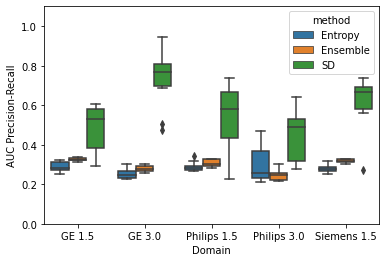

In [210]:
sns_plot = sns.boxplot(x="Domain", y="AUC Precision-Recall",
            hue="method", data=df_pr_calgary)
plt.ylim(0, 1.1)
fig = sns_plot.get_figure()
fig.savefig("calgary_auc_pr.jpg")

In [119]:
df_pr_mms = pd.DataFrame(columns=['method', 'Domain', 'run', 'AUC Precision-Recall'])

out = None
best = 0

for method in ['base', 'ensemble', 'ae']:
    for scanner in ['val', 'A', 'B', 'C', 'D']:
        tmp = get_pixel_data(method=method, 
                             net_out='mms', 
                             scanner=str(scanner))
        for i, metric_obj in enumerate(tmp):
            if metric_obj.auc_pr.item() > best:
                best = metric_obj.auc_pr.item()
                idx = i
                s = scanner
                out=metric_obj
                
                print(out.auc_pr, s, idx)
            
            if scanner == 'A':
                domain = 'Siemens'
            if scanner == 'B':
                domain = 'Philips'
            if scanner == 'C':
                domain = 'GE'
            if scanner == 'D':
                domain = 'Canon'
            if scanner == 'val':
                domain = 'Siemens \n(val)'
                #print("hi")

            if method == 'base':
                m = 'Entropy'
            if method == 'ensemble':
                m = 'Ensemble'
            if method == 'ae':
                m = 'SD (ours)'

            row = {'Domain': domain, 
                   'method': m, 
                   'run': i,
                   'AUC Precision-Recall': metric_obj.auc_pr.item()}

            df_pr_mms = df_pr_mms.append(row, ignore_index=True)




0.455599844455719 val 0
0.5541420578956604 val 1


In [61]:
df_pr_mms

,method,Domain,run,AUC Precision-Recall
0,Entropy,Siemens,0,0.437034
1,Entropy,Siemens,1,0.510325
2,Entropy,Siemens,2,0.471397
3,Entropy,Siemens,3,0.445948
4,Entropy,Siemens,4,0.488623
...,...,...,...,...
145,SD (ours),Canon,15,0.288269
146,SD (ours),Canon,16,0.247454
147,SD (ours),Canon,17,0.373235
148,SD (ours),Canon,18,0.276603


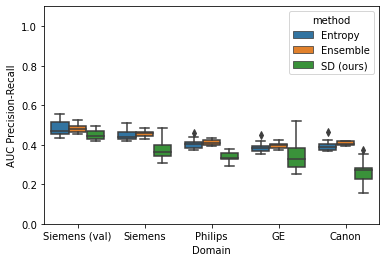

In [66]:
sns_plot = sns.boxplot(x="Domain", y="AUC Precision-Recall",
            hue="method", data=df_pr_mms)
plt.ylim(0, 1.1)
fig = sns_plot.get_figure()
fig.savefig("mms_auc_pr.jpg")

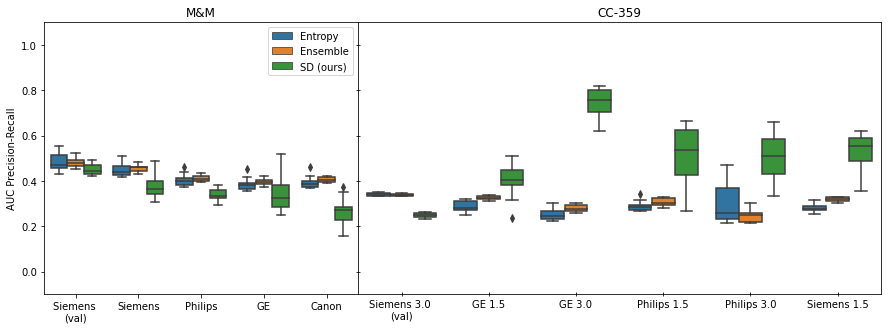

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 5]}, sharey=True)

axes[0].set_title('M&M')
axes[1].set_title('CC-359')
#

sns.boxplot(ax=axes[0], x="Domain", y="AUC Precision-Recall",
            hue="method", data=df_pr_mms)

sns.boxplot(ax=axes[1], x="Domain", y="AUC Precision-Recall",
            hue="method", data=df_pr_calgary)

axes[0].set_ylim(-0.1, 1.1)
axes[0].legend().set_title('')
axes[0].set_xlabel("")
axes[1].get_legend().remove()
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(direction='inout')
fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("../../experiments/results/eval/voxel_wise.jpg", bbox_inches='tight')

In [ ]:
fig = plt.figure(layout="constrained", figsize=(15,5))
sfigs = fig.subfigures(1, 2, width_ratios=[1, 2])

axs_left = sfigs[0].subplots(1, 1)
axs_left.set_title('M&M - ODD Detection')

sns.boxplot(ax=axs_left, x="Domain", y="Accuracy",
        hue="method", data=df_ood_mms)
axs_left.legend().set_title('')

axs_right = sfigs[1].subplots(1, 2, sharey=True)
sns.boxplot(ax = axs_right[0], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_mms)
axs_right[0].get_legend().remove()
axs_right[0].set_title('M&M - Error Correlation')

sns.boxplot(ax = axs_right[1], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_calgary)
axs_right[1].get_legend().remove()
axs_right[1].set_title('CC-359 - Error Correlation')

#axs_right[1].set_yticks([])
axs_right[1].set_ylabel("")
axs_right[1].set_ylim(-0.3, 1.1)
#sfigs[1].subplots_adjust(wspace=0, hspace=0)
#fig.colorbar(pcm, ax=axs_right)
#fig.suptitle('Nested plots using subfigures')
fig.savefig("image_wise.jpg")

ValueError: Could not interpret input 'Pearson's Correlation'

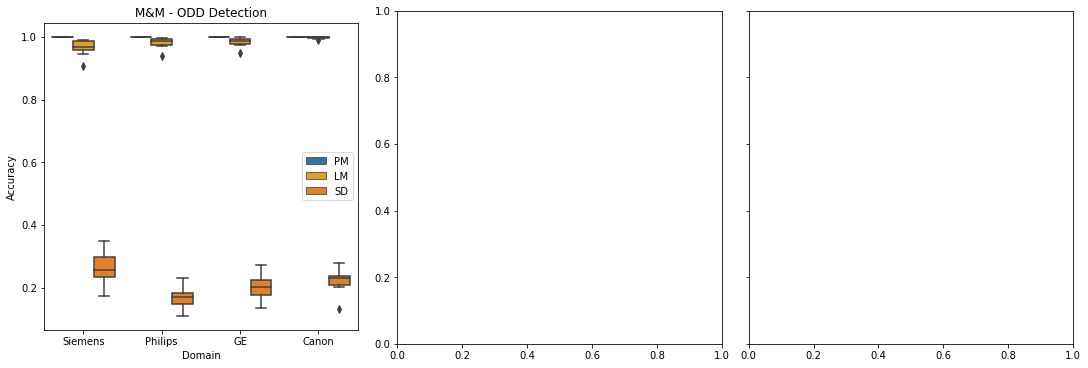

In [94]:
fig = plt.figure(layout="constrained", figsize=(15,5))
sfigs = fig.subfigures(1, 2, width_ratios=[1, 2])

axs_left = sfigs[0].subplots(1, 1)
axs_left.set_title('M&M - ODD Detection')

sns.boxplot(ax=axs_left, x="Domain", y="Accuracy",
        hue="method", data=df_ood_mms, palette=custom_palette)
axs_left.legend().set_title('')

axs_right = sfigs[1].subplots(1, 2, sharey=True)
sns.boxplot(ax = axs_right[0], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_mms, palette=custom_palette)
axs_right[0].get_legend().remove()
axs_right[0].set_title('M&M - Error Correlation')

sns.boxplot(ax = axs_right[1], x="Domain", y="Pearson\'s Correlation",
            hue="method", data=df_corr_calgary)
axs_right[1].get_legend().remove()
axs_right[1].set_title('CC-359 - Error Correlation')

#axs_right[1].set_yticks([])
axs_right[1].set_ylabel("")
axs_right[1].set_ylim(-0.3, 1.1)
#sfigs[1].subplots_adjust(wspace=0, hspace=0)
#fig.colorbar(pcm, ax=axs_right)
#fig.suptitle('Nested plots using subfigures')
fig.savefig("image_wise.jpg")